In [1]:
import xarray as xr
# import matplotlib.pyplot as plt
import datetime
from glob import glob
import dask, dask.distributed
import dask_jobqueue
import matplotlib.pyplot as plt
import datetime
import numpy as np
# import parcels
import warnings
warnings.filterwarnings("ignore")
import lt_toolbox as ltt
import cartopy.crs as ccrs
import pandas as pd
from xhistogram.xarray import histogram as xhist
import seawater as gsw

In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='16GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='04:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=15) #15
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.18.4.21:8787/status,
Dashboard: http://172.18.4.21:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.18.4.21:33717,Workers: 0
Dashboard: http://172.18.4.21:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:

mesh_mask = xr.open_dataset('../../Data/mesh_masks/mesh_mask.nc')
mesh_hzgr = xr.open_dataset('../../Data/mesh_masks/mesh_hzgr.nc')
mesh_hgr = xr.open_dataset('../../Data/mesh_masks/mesh_hgr.nc')

In [4]:
ds = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')

In [5]:
# Find particles where salinity reaches 0 at any observation point
particles_reach_zero_salinity = (ds.salt == 0).any('obs')

particles_beached = ~particles_reach_zero_salinity

# Filter the dataset to include only particles that reach zero salinity
ds_particles_reach_zero_salinity_beached = ds.where(particles_beached, drop=False)
ds = ds_particles_reach_zero_salinity_beached

ds_density = xr.apply_ufunc(gsw.eos80.pden,ds.salt,ds.temp,0,dask='parallelized',output_dtypes=[np.float64]) - 1000

# assigning density to the ds!
ds_add_dens = ds.assign(sigma0=ds_density)
ds = ds_add_dens

In [6]:

import yaml
import os
outdir = 'data/level3/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
if os.path.exists(f'{outdir}/minmax.yaml'):
    with open(f'{outdir}/minmax.yaml', 'r') as file:
        results = yaml.load(file, Loader=yaml.FullLoader)
else:
    results = calc_min_max(ds)
    with open(f'{outdir}/minmax.yaml', 'w') as file:
        yaml.dump(results, file)

n=0.25
lon_bins = np.arange(results['lon_min'], results['lon_max'], n)
lat_bins = np.arange(results['lat_min'], results['lat_max'], n)

def rechunk_for_hist(var):
    return var.chunk({'trajectory': 50, 'obs': -1})

lon_rechunk = rechunk_for_hist(ds['lon'])
lat_rechunk = rechunk_for_hist(ds['lat'])

In [7]:
land_mask = mesh_mask.tmask.where(mesh_mask.tmask!=0).isel(t=0,z=0)

heat_map_obs = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=['obs'],
    bin_dim_suffix="") #dim=['obs'],

heat_map_traj = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], #, dim=['trajectory'], # with dim=trajectory, the  chunks were way too big over 5 Gib
    bin_dim_suffix="")

# Summing particle counts over the whole integration period
heat_map_obs_sum = heat_map_traj#.sum(dim='obs')

# Dividing by the total number of particle counts for all bins
total_counts = heat_map_obs_sum.sum()
heat_map_normalized = heat_map_obs_sum / total_counts

# Calculate the total number of observations
total_observations = ds.obs.size

# Calculate the probability for each bin
heat_map_probability_obs = (heat_map_obs / total_observations) * 100

# Summing particle counts over the whole integration period, considering each particle only once per bin
heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')

# Dividing by the total number of particles to get the probability for each bin
total_particles = ds.trajectory.size
heat_map_probability = (heat_map_obs_unique / total_particles) * 100

heat_map_normalized_comp = heat_map_normalized.compute()

In [8]:
# Summing particle counts over the whole integration period, considering each particle only once per bin
heat_map_obs_unique = (heat_map_obs > 0).sum(dim='trajectory')

# Dividing by the total number of particles to get the probability for each bin
total_particles = ds.trajectory.size
heat_map_probability = (heat_map_obs_unique / total_particles) * 100

heat_map_probability_compute = heat_map_probability.compute()

In [9]:
#heat_map_probability_compute

mask_0_probability = xr.where(100*heat_map_normalized_comp>0.001,1, np.nan)
mask_0_probability = mask_0_probability.rename({'lat':'lat_bin','lon':'lon_bin'})

In [10]:
def get_mean_maps(ds,lon_rechunk,lat_rechunk):
    weights = xr.ones_like(ds)
    weighted_sum = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=ds, dim=["obs", "trajectory"])
    counts = xhist(lon_rechunk, lat_rechunk, bins=[lon_bins, lat_bins], weights=weights, dim=["obs", "trajectory"])
    mean_temp = weighted_sum / counts
    return mean_temp

mean_salt = get_mean_maps(ds.salt,lon_rechunk,lat_rechunk)
mean_age = get_mean_maps(ds.age,lon_rechunk,lat_rechunk)
mean_temp = get_mean_maps(ds.temp,lon_rechunk,lat_rechunk)

In [11]:
%%time 

mean_age_cp = mean_age.compute()

CPU times: user 52.7 s, sys: 2.23 s, total: 54.9 s
Wall time: 1min 7s


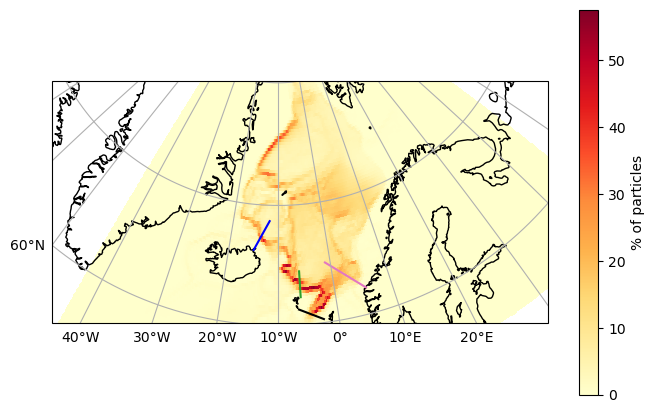

In [11]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=-10, central_latitude=77))
ax.set_extent([-50, 40, 60, 75], crs=ccrs.PlateCarree())
# Plot the bathymetry data on the orthographic map
pcolormesh = ax.pcolormesh(
    mesh_mask.nav_lon,mesh_mask.nav_lat,land_mask, 
    transform=ccrs.PlateCarree(), cmap='binary')
# Add color bar for bathymetry
#plt.colorbar(pcolormesh, ax=ax, orientation="vertical", label="bathymetry (m)")

x = ax.pcolormesh(heat_map_probability_compute.lon,heat_map_probability_compute.lat,heat_map_probability_compute,cmap='YlOrRd',transform=ccrs.PlateCarree())
cbar=plt.colorbar(x)
cbar.set_label(r'% of particles')
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 10))  # Set x-axis grid line intervals
gl.ylocator = plt.FixedLocator(np.arange(-90, 91, 10))    # Set y-axis grid line intervals
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# EIC
#ax.plot([-15,-11.95],[66.25,68.7], color='red', transform=ccrs.PlateCarree())

# release
#ax.plot([-6.5, -1], [62.1, 60.5], color='red', transform=ccrs.PlateCarree())

# eastern side
#ax.plot([-8, -5], [62.5, 64.5], color='green', transform=ccrs.PlateCarree(),label='West')

ax.plot([-15, -11.95], [66.25, 68.7], color='blue',label='EIC', transform=ccrs.PlateCarree())
# west 

ax.plot([-6.0833, -6.0833], [62.3333, 64.5], color='tab:green', label='N section',transform=ccrs.PlateCarree())


ax.plot([5.5, -1], [62.24, 65.], color='tab:pink', label='Svinoy section',transform=ccrs.PlateCarree())
#ax.plot([-15, -11.95], [66.25, 68.7], color='k',transform=ccrs.PlateCarree())
# ax.plot([-15, -11.95], [66.25 + dist, 68.7 + dist], color='red',transform=ccrs.PlateCarree())
# ax.plot([-15, -11.95], [66.25 - dist, 68.7 - dist], color='red',transform=ccrs.PlateCarree())

#ax.plot([-16, -10], [66.25, 69.16], color='blue',transform=ccrs.PlateCarree()) 

#ax.legend()
# # 
# ax.plot([8,0],[63,66], color='k', transform=ccrs.PlateCarree())


# particle release 

ax.plot([-6.5, -2.5], [61.3, 60.3], color='k', transform=ccrs.PlateCarree())
#plt.title('probability of particle distribution released from 2003 - 2020')
plt.show()


In [174]:
# obs = xr.open_dataset('/gxfs_work/geomar/smomw452/GLORYS12/Data/GSR_FAROECURR_SSN_CTD_1m_1987_2023.nc')
# obs

In [13]:
# shapely -- line segments, intersection
# is xi above or below for the N section

# list of trajectories inside box
# make line based on y=mx+b  -- intial ending point
# check trajectory points below and above the line 
# find where there's 0, 1 pairing per trajectory  - for each traj in box, check each point above or below, check 0s and 1, yes crossing 

In [14]:
# Define the first section
EIC = (ds.lon > -15) & (ds.lat > 66.25) & (ds.lon < -11.95) & (ds.lat < 68.7)  #plot([-15, -11.95], [66.25, 68.7] plot([-15, -11.95], [66.25, 68.7] -- -16) & (ds.lat > 66.25) & (ds.lon < -10) & (ds.lat < 69.16)

Svinoy = (ds.lon < 5.5) & (ds.lat > 62.24) & (ds.lon > -1) & (ds.lat < 65) 

N_section = (ds.lon > -6.0833-5) & (ds.lat > 62.3333) & (ds.lon < -6.0833+5) & (ds.lat < 64.5)


In [15]:
Svinoy_box = ds.where(Svinoy, drop=False)
EIC_box = ds.where(EIC, drop=False)
N_box = ds.where(N_section, drop=False)

In [12]:
#np.arange(10,ds.trajectory.size,50_000)

In [16]:
import tqdm
# for i in tqdm.tqdm(np.arange(1,ds.trajectory.size,50_000)):
#     EIC_box.isel(trajectory=i).temp.plot()
#     Svinoy_box.isel(trajectory=i).temp.plot()
#     plt.show()

In [18]:
#plt.pcolormesh(ds_EIC_line_map.lon, ds_EIC_line_map.lat, ds_EIC_line_map.where(ds_EIC_line_map > 0), cmap='YlOrRd')

In [17]:
def calculate_slope_intercept(x1, y1, x2, y2):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b


# Calculate slope and intercept
dist = .4
m_Svinoy, b_Svinoy = calculate_slope_intercept(5.5, 62.24-dist, -1, 65-dist)
m_Svinoy2, b_Svinoy2 = calculate_slope_intercept(5.5, 62.24+dist, -1, 65+dist) #.8 comes from max 2m/s velocity*12h = 86km convert km to degree = ~.77 degree
# but use area with cross section line as midpoint 
# Print the results
print("slope (m) is:", m_Svinoy)
print("y-intercept (b) is:", b_Svinoy)



slope (m) is: -0.42461538461538323
y-intercept (b) is: 64.17538461538462


In [18]:
m_EIC, b_EIC = calculate_slope_intercept(-15, 66.25-dist, -11.95, 68.7-dist) # (-15, 66.25-dist, -11.95, 68.7-dist) # extended - -16, 66.25-dist, -10, 69.16-dist)
m_EIC2, b_EIC2 = calculate_slope_intercept(-15, 66.25+dist, -11.95, 68.7+dist)
print("slope (m) is:", m_EIC, m_EIC2)
print("y-intercept (b) is:", b_EIC, b_EIC2)


slope (m) is: 0.803278688524591 0.803278688524591
y-intercept (b) is: 77.89918032786886 78.69918032786887


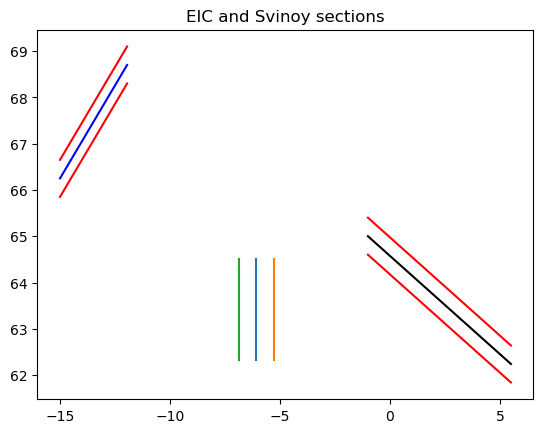

In [19]:
#plt.plot([-16, -10.95], [66.25, 68.7], color='k') # plt.plot([-16, -10], [66.25, 69.16], color='blue') ax': -9.5, 'lat_min': 66.25, 'lat_max': 69.41
plt.plot([-15, -11.95], [66.25, 68.7], color='blue')  #(-15, 66.25-dist, -11.95, 68.7-dist)
plt.plot([-15, -11.95], [66.25 + dist, 68.7 + dist], color='red')
plt.plot([-15, -11.95], [66.25 - dist, 68.7 - dist], color='red')

plt.plot([5.5, -1], [62.24, 65.],color='k')
plt.plot([5.5, -1], [62.24+.4, 65+.4],color='red')
plt.plot([5.5, -1], [62.24-.4, 65-.4],color='red')

plt.plot([-6.0833, -6.0833], [62.3333, 64.5])
plt.plot([-6.0833+.8, -6.0833+.8], [62.3333, 64.5])
plt.plot([-6.0833-.8, -6.0833-.8], [62.3333, 64.5])


plt.title('EIC and Svinoy sections')
plt.show()

In [31]:
#Svinoy_box = ds.where(Svinoy)

# y_values = m_Svinoy * Svinoy_box.lon + b_Svinoy

# lat_lon_points = Svinoy_box.where(Svinoy_box.lat >= y_values, drop=False)


In [156]:
#ds_svinoy_line = ds.lat >= ds.lon*m_Svinoy + b_Svinoy # if latitude baove that line, set to True

# ds lon, above or below that value. 

In [21]:
# Svinoy section

ds_Svinoy_window = Svinoy_box.lat >= Svinoy_box.lon*m_Svinoy + b_Svinoy  #if latitude above that line, set to True
ds_Svinoy_window2 = Svinoy_box.lat <= Svinoy_box.lon*m_Svinoy2 + b_Svinoy2  #if latitude BELOW that line, set to True
ds_Svinoy_line_cross = (Svinoy_box.lat >= Svinoy_box.lon * m_Svinoy + b_Svinoy) & (Svinoy_box.lat <= Svinoy_box.lon * m_Svinoy2 + b_Svinoy2)

ds_Svinoy_window = ds_Svinoy_window.astype(int)
ds_Svinoy_window2 = ds_Svinoy_window2.astype(int)
ds_Svinoy_line_cross = ds_Svinoy_line_cross.astype(int)

#ds_Svinoy_window
ds_Svinoy = ds.where(ds_Svinoy_window, drop=False)
ds_Svinoy2 = ds.where(ds_Svinoy_window2, drop=False)

ds_Svinoy_line = ds.where(ds_Svinoy_window & ds_Svinoy_window2, drop=False)

In [22]:
# EIC section

ds_EIC_window = EIC_box.lat >= EIC_box.lon*m_EIC + b_EIC  #if latitude above that line, set to True
ds_EIC_window2 = EIC_box.lat <= EIC_box.lon*m_EIC2 + b_EIC2  #if latitude BELOW that line, set to True
ds_EIC_line_cross = (EIC_box.lat >= EIC_box.lon*m_EIC + b_EIC) & (EIC_box.lat <= EIC_box.lon*m_EIC2 + b_EIC2)

ds_EIC_window = ds_EIC_window.astype(int)
ds_EIC_window2 = ds_EIC_window2.astype(int)
ds_EIC_line_cross = ds_EIC_line_cross.astype(int)

#ds_EIC_window
ds_EIC = ds.where(ds_EIC_window, drop=False)
ds_EIC2 = ds.where(ds_EIC_window2, drop=False)

ds_EIC_line = ds.where(ds_EIC_window & ds_EIC_window2, drop=False)

In [24]:
# N section

ds_N_window = (N_box.lon <= -6.0833+.1).astype(int)
ds_N_window2  = (N_box.lon >= -6.0833-.1).astype(int)
ds_N_line_cross = (N_box.lon <= -6.0833+.1) & (N_box.lon >= -6.0833-.1).astype(int)

ds_N = ds.where(ds_N_window, drop=False)
ds_N2 = ds.where(ds_N_window2, drop=False)

ds_N_line = ds.where(ds_N_window & ds_N_window2,drop=False)

In [75]:
# this matches with the # of counts and crossings!

for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
    ds_Svinoy.temp.isel(trajectory=i).plot()
    plt.close()
    
    ds_Svinoy_window.isel(trajectory=i).astype(int).plot()
    plt.close()

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


In [25]:
# # not applying the box here! 

# ds_Svin = ds.lat >= ds.lon*m_Svinoy + b_Svinoy 
# ds_Svin = ds.where(ds_Svin, drop=False)

In [ ]:
#test = ds[['salt','sigma0','temp','vvel', 'z','age']].where(ds_Svinoy_window, np.nan)

In [45]:
# for i in tqdm.tqdm(np.arange(1,ds.trajectory.size,50_000)):
#     ds_Svinoy_window.isel(trajectory=i).plot()
#     ds_Svin.isel(trajectory=i).plot()
#     plt.show()

In [29]:
# for i in tqdm.tqdm(np.arange(1,ds.trajectory.size,50_000)):
#     ds.isel(trajectory=i).temp.plot()
#     test.isel(trajectory=i).temp.plot()
#     plt.show()

In [26]:
def compute_heat_map(ds): #.nbytes/1e9
    heat_map_traj = xhist(ds.lat, ds.lon, bins=[lat_bins, lon_bins], bin_dim_suffix="") 
    total_counts = heat_map_traj.sum()
    heat_map_normalized = heat_map_traj / total_counts
    heat_map_normalized_cp = heat_map_normalized.compute()
    return heat_map_normalized_cp

ds_Svinoy_map = compute_heat_map(ds_Svinoy)
ds_Svinoy_map2 = compute_heat_map(ds_Svinoy2)
ds_Svinoy_line_map = compute_heat_map(ds_Svinoy_line)

In [27]:
ds_EIC_map = compute_heat_map(ds_EIC)
ds_EIC_map2 = compute_heat_map(ds_EIC2)
ds_EIC_line_map = compute_heat_map(ds_EIC_line)


In [28]:
ds_N_map = compute_heat_map(ds_N)
ds_N_map2 = compute_heat_map(ds_N2)
ds_N_line_map = compute_heat_map(ds_N_line)

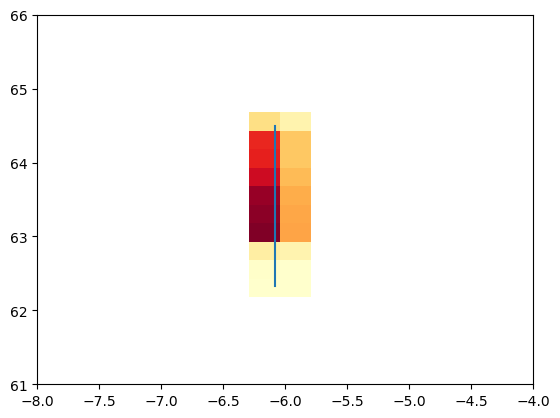

In [29]:
plt.pcolormesh(ds_N_line_map.lon, ds_N_line_map.lat, ds_N_line_map.where(ds_N_line_map > 0), cmap='YlOrRd')
plt.plot([-6.0833, -6.0833], [62.3333, 64.5])
plt.ylim(61, 66)
plt.xlim(-8,-4);

In [30]:

# plt.pcolormesh(EIC_box_map.lon, EIC_box_map.lat, EIC_box_map.where(EIC_box_map > 0), cmap='viridis')

# plt.plot([-15, -11.95], [66.25, 68.7], color='k')
# plt.plot([-15, -11.95], [66.25 + dist, 68.7 + dist], color='red')
# plt.plot([-15, -11.95], [66.25 - dist, 68.7 - dist], color='red')
# plt.xlim(-20,-8)
# plt.ylim(65,70)

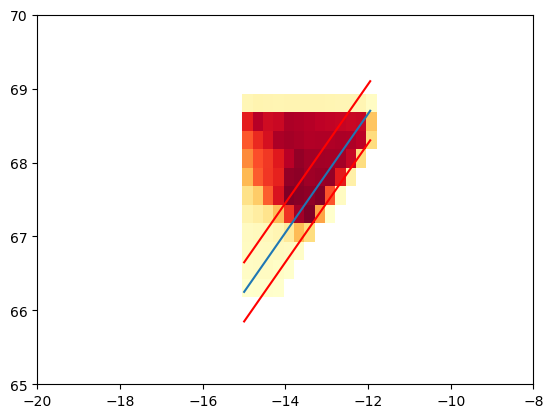

In [ ]:

plt.pcolormesh(ds_EIC_map.lon, ds_EIC_map.lat, ds_EIC_map.where(ds_EIC_map > 0), cmap='YlOrRd')
plt.plot([-15, -11.95], [66.25, 68.7],color='k')
plt.plot([-15, -11.95], [66.25 + dist, 68.7 + dist], color='red')
plt.plot([-15, -11.95], [66.25 - dist, 68.7 - dist], color='red')
plt.xlim(-20,-8)
plt.ylim(65,70);

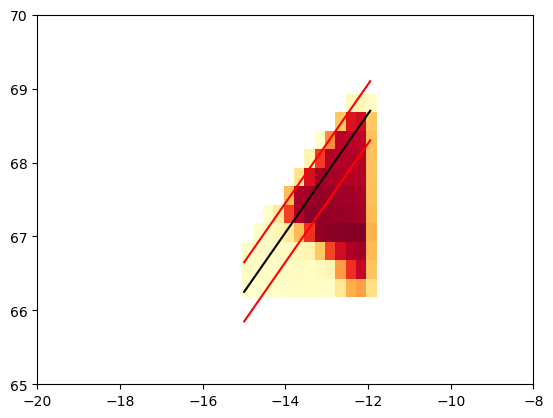

In [40]:
plt.pcolormesh(ds_EIC_map2.lon, ds_EIC_map2.lat, ds_EIC_map2.where(ds_EIC_map2 > 0), cmap='YlOrRd')
plt.plot([-15, -11.95], [66.25, 68.7],color='k')
plt.plot([-15, -11.95], [66.25 + dist, 68.7 + dist], color='red')
plt.plot([-15, -11.95], [66.25 - dist, 68.7 - dist], color='red')
plt.xlim(-20,-8)
plt.ylim(65,70)
plt.show()

(65.0, 70.0)

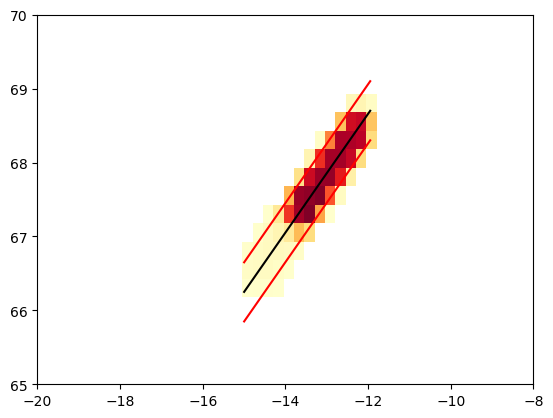

In [38]:

plt.pcolormesh(ds_EIC_line_map.lon, ds_EIC_line_map.lat, ds_EIC_line_map.where(ds_EIC_line_map > 0), cmap='YlOrRd')
plt.plot([-15, -11.95], [66.25, 68.7],color='k')
plt.plot([-15, -11.95], [66.25 + dist, 68.7 + dist], color='red')
plt.plot([-15, -11.95], [66.25 - dist, 68.7 - dist], color='red')
plt.xlim(-20,-8)
plt.ylim(65,70)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


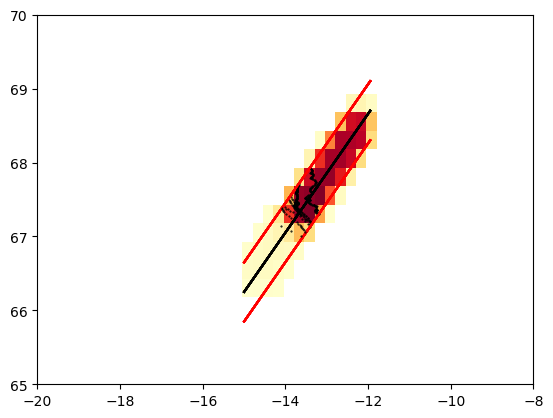

In [39]:
for i in tqdm.tqdm(np.arange(10, ds.trajectory.size, 50_000)):
    plt.pcolormesh(ds_EIC_line_map.lon, ds_EIC_line_map.lat, ds_EIC_line_map.where(ds_EIC_line_map > 0), cmap='YlOrRd')
    plt.plot([-15, -11.95], [66.25, 68.7],color='k')
    plt.plot([-15, -11.95], [66.25 + dist, 68.7 + dist], color='red')
    plt.plot([-15, -11.95], [66.25 - dist, 68.7 - dist], color='red')
    plt.plot(ds_EIC_line.isel(trajectory=i).lon, ds_EIC_line.isel(trajectory=i).lat, 'k.', markersize=1)
    plt.xlim(-20,-8)
    plt.ylim(65,70)
plt.show()

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


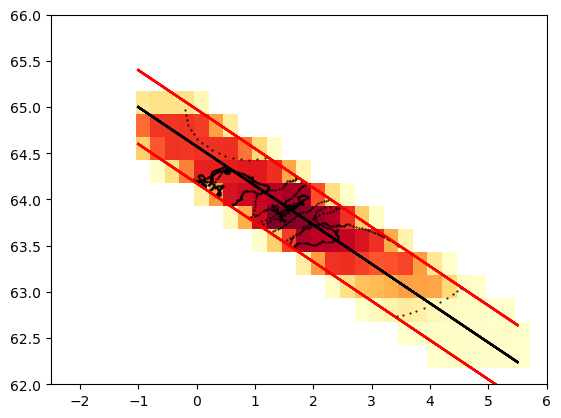

In [41]:
for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
    plt.pcolormesh(ds_Svinoy_line_map.lon,ds_Svinoy_line_map.lat,ds_Svinoy_line_map.where(ds_Svinoy_line_map>0),cmap='YlOrRd')
    plt.plot([5.5, -1], [62.24, 65.],color='k')
    plt.plot([5.5, -1], [62.24+.4, 65+.4],color='red')
    plt.plot([5.5, -1], [62.24-.4, 65-.4],color='red')
    plt.plot(ds_Svinoy_line.isel(trajectory=i).lon,ds_Svinoy_line.isel(trajectory=i).lat,'k.',markersize=1)
    plt.xlim(-2.5,6)
    plt.ylim(62,66)
plt.show()

100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


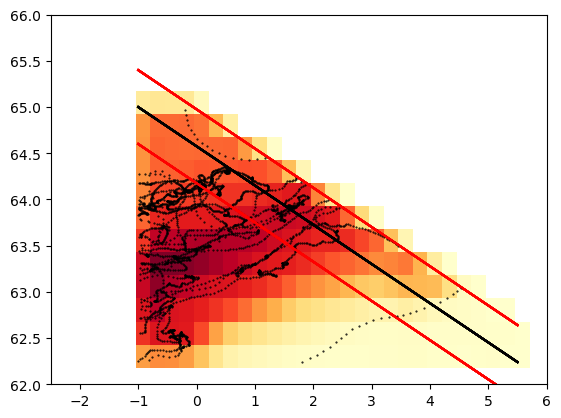

In [42]:
for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
    plt.pcolormesh(ds_Svinoy_map2.lon,ds_Svinoy_map2.lat,ds_Svinoy_map2.where(ds_Svinoy_map2>0),cmap='YlOrRd')
    plt.plot([5.5, -1], [62.24, 65.],color='k')
    plt.plot([5.5, -1], [62.24+.4, 65+.4],color='red')
    plt.plot([5.5, -1], [62.24-.4, 65-.4],color='red')
    plt.plot(ds_Svinoy2.isel(trajectory=i).lon,ds_Svinoy2.isel(trajectory=i).lat,'k.',markersize=1)
    plt.xlim(-2.5,6)
    plt.ylim(62,66)
plt.show()


100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


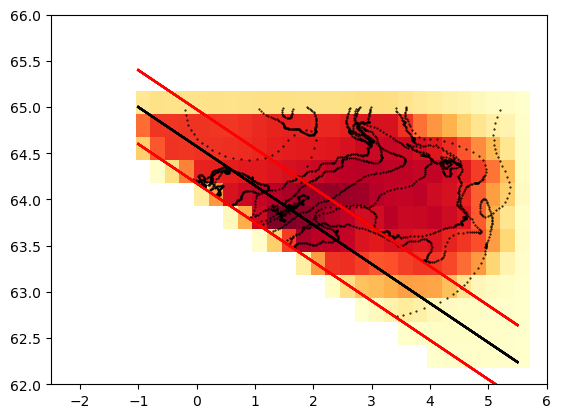

In [43]:
for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
    plt.pcolormesh(ds_Svinoy_map.lon,ds_Svinoy_map.lat,ds_Svinoy_map.where(ds_Svinoy_map>0),cmap='YlOrRd')
    plt.plot([5.5, -1], [62.24, 65.],color='k')
    plt.plot([5.5, -1], [62.24+.4, 65+.4],color='red')
    plt.plot([5.5, -1], [62.24-.4, 65-.4],color='red')
    plt.plot(ds_Svinoy.isel(trajectory=i).lon,ds_Svinoy.isel(trajectory=i).lat,'k.',markersize=1)
    plt.xlim(-2.5,6)
    plt.ylim(62,66)
plt.show()

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


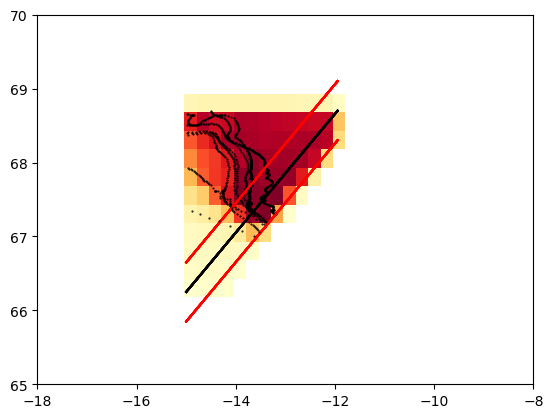

In [44]:
for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
    plt.pcolormesh(ds_EIC_map.lon, ds_EIC_map.lat, ds_EIC_map.where(ds_EIC_map > 0), cmap='YlOrRd')
    plt.plot([-15, -11.95], [66.25, 68.7],color='k')
    plt.plot([-15, -11.95], [66.25 + dist, 68.7 + dist], color='red')
    plt.plot([-15, -11.95], [66.25 - dist, 68.7 - dist], color='red')
    plt.plot(ds_EIC.isel(trajectory=i).lon, ds_EIC.isel(trajectory=i).lat, 'k.', markersize=1)
    plt.xlim(-18,-8)
    plt.ylim(65,70)
plt.show()

100%|██████████| 10/10 [00:13<00:00,  1.37s/it]


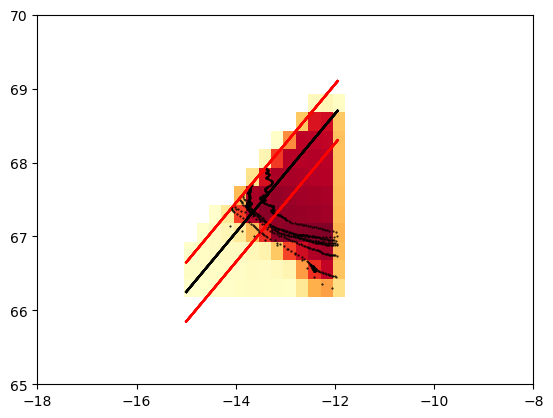

In [45]:
for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
    plt.pcolormesh(ds_EIC_map2.lon, ds_EIC_map2.lat, ds_EIC_map2.where(ds_EIC_map2 > 0), cmap='YlOrRd')
    plt.plot([-15, -11.95], [66.25, 68.7],color='k')
    plt.plot([-15, -11.95], [66.25 + dist, 68.7 + dist], color='red')
    plt.plot([-15, -11.95], [66.25 - dist, 68.7 - dist], color='red')
    plt.plot(ds_EIC2.isel(trajectory=i).lon, ds_EIC2.isel(trajectory=i).lat, 'k.', markersize=1)
    plt.xlim(-18,-8)
    plt.ylim(65,70)
plt.show()

100%|██████████| 17/17 [00:32<00:00,  1.92s/it]


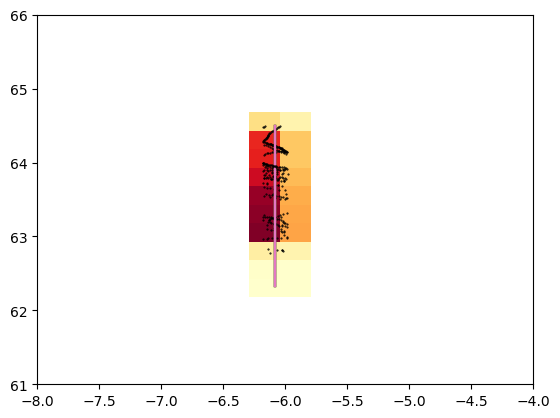

In [47]:
for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,30_000)):
    plt.pcolormesh(ds_N_line_map.lon, ds_N_line_map.lat, ds_N_line_map.where(ds_N_line_map > 0), cmap='YlOrRd')
    plt.plot([-6.0833, -6.0833], [62.3333, 64.5])
    plt.ylim(61, 66)
    plt.xlim(-8,-4)
    plt.plot(ds_N_line.isel(trajectory=i).lon, ds_N_line.isel(trajectory=i).lat, 'k.', markersize=1)
plt.show()

In [52]:
#np.arange(10,ds.trajectory.size,50_000)

i = np.arange(10,ds.trajectory.size,50_000)

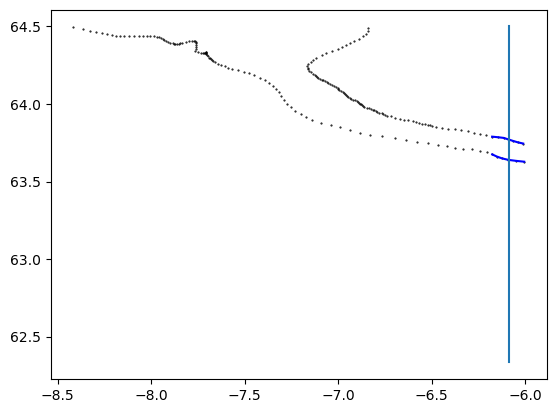

In [53]:
plt.plot(ds_N.isel(trajectory=i[3]).lon,ds_N.isel(trajectory=i[3]).lat,'k.',markersize=1)
plt.plot(ds_N_line.isel(trajectory=i[3]).lon,ds_N_line.isel(trajectory=i[3]).lat,'b',markersize=1)
plt.plot([-6.0833, -6.0833], [62.3333, 64.5]);

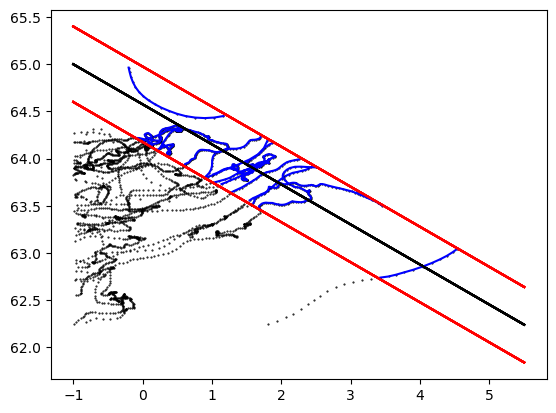

In [55]:
#ds_Svinoy_window.isel(trajectory=i[2]).argmax(dim='obs').values

for x in i:
    plt.plot(ds_Svinoy2.isel(trajectory=x).lon,ds_Svinoy2.isel(trajectory=x).lat,'k.',markersize=1)
    plt.plot(ds_Svinoy_line.isel(trajectory=x).lon,ds_Svinoy_line.isel(trajectory=x).lat,'b',markersize=1)
    plt.plot([5.5, -1], [62.24, 65.],color='k')
    plt.plot([5.5, -1], [62.24+.4, 65+.4],color='red')
    plt.plot([5.5, -1], [62.24-.4, 65-.4],color='red')
plt.show()


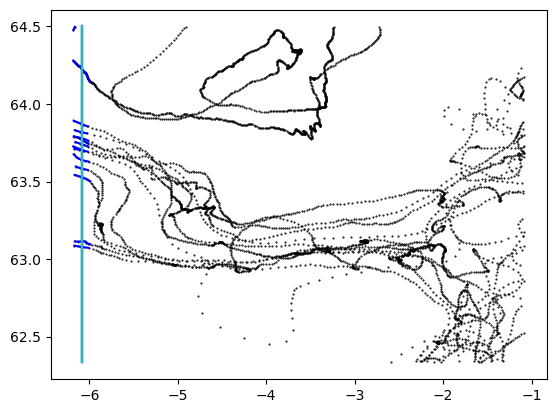

In [56]:
#ds_Svinoy_window.isel(trajectory=i[2]).argmax(dim='obs').values

for x in i:
    plt.plot(ds_N2.isel(trajectory=x).lon,ds_N2.isel(trajectory=x).lat,'k.',markersize=1)
    plt.plot(ds_N_line.isel(trajectory=x).lon,ds_N_line.isel(trajectory=x).lat,'b',markersize=1)
    # plt.plot([-16, -10], [66.25, 69.16], color='blue') 
    # plt.plot([-16, -10], [66.25 + dist, 69.16 + dist], color='red')
    # plt.plot([-16, -10.], [66.25 - dist, 69.16 - dist], color='red')
    plt.plot([-6.0833, -6.0833], [62.3333, 64.5])
plt.show()


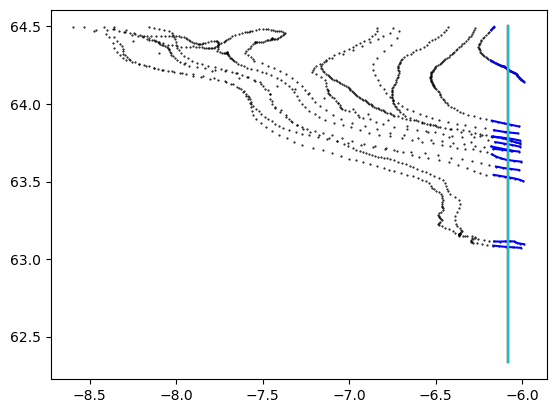

In [59]:
for x in i:
    plt.plot(ds_N.isel(trajectory=x).lon,ds_N.isel(trajectory=x).lat,'k.',markersize=1)
    plt.plot(ds_N_line.isel(trajectory=x).lon,ds_N_line.isel(trajectory=x).lat,'b',markersize=1)
    # plt.plot([-16, -10], [66.25, 69.16], color='blue') 
    # plt.plot([-16, -10], [66.25 + dist, 69.16 + dist], color='red')
    # plt.plot([-16, -10.], [66.25 - dist, 69.16 - dist], color='red')
    plt.plot([-6.0833, -6.0833], [62.3333, 64.5])
plt.show()


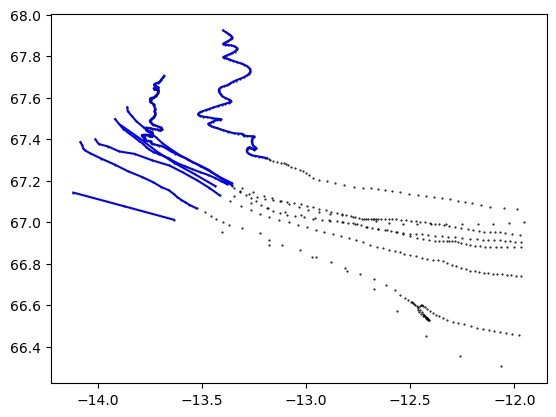

In [60]:
#ds_Svinoy_window.isel(trajectory=i[2]).argmax(dim='obs').values

for x in i:
    plt.plot(ds_EIC2.isel(trajectory=x).lon,ds_EIC2.isel(trajectory=x).lat,'k.',markersize=1)
    plt.plot(ds_EIC_line.isel(trajectory=x).lon,ds_EIC_line.isel(trajectory=x).lat,'b',markersize=1)
plt.show()


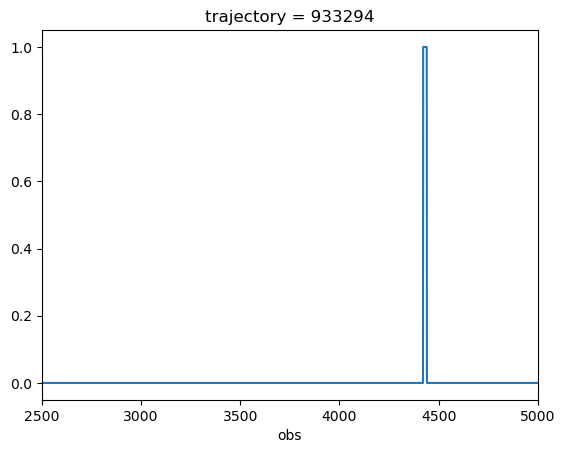

In [64]:
ds_Svinoy_line_cross.isel(trajectory=i[3]).plot()
plt.xlim(2500,5000);

In [62]:
# for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
#     ds_Svinoy_line_cross.isel(trajectory=i).plot()
# plt.show()

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


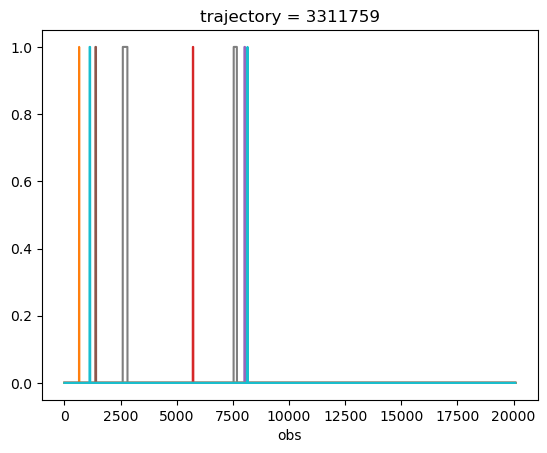

In [140]:
for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
    ds_EIC_line_cross.isel(trajectory=i).plot()
plt.show()

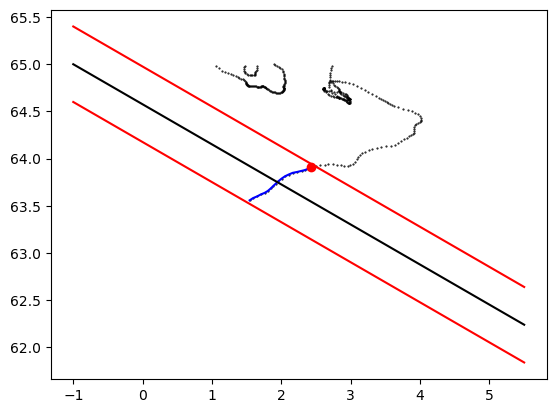

In [72]:
first_index_line_cross = ds_Svinoy_line_cross.isel(trajectory=i[3]).argmax(dim='obs').values

i = np.arange(10,ds.trajectory.size,50_000)
plt.plot(ds_Svinoy.isel(trajectory=i[3]).lon,ds_Svinoy.isel(trajectory=i[3]).lat,'k.',markersize=1)
plt.plot(ds_Svinoy_line.isel(trajectory=i[3]).lon,ds_Svinoy_line.isel(trajectory=i[3]).lat,'b',markersize=1)
plt.plot([5.5, -1], [62.24, 65.],color='k')
plt.plot([5.5, -1], [62.24+.4, 65+.4],color='red')
plt.plot([5.5, -1], [62.24-.4, 65-.4],color='red')
plt.plot(ds_Svinoy_line.isel(trajectory=i[3]).lon[first_index_line_cross].values,
         ds_Svinoy_line.isel(trajectory=i[3]).lat[first_index_line_cross].values, 'ro', label='first crossing')
plt.show()

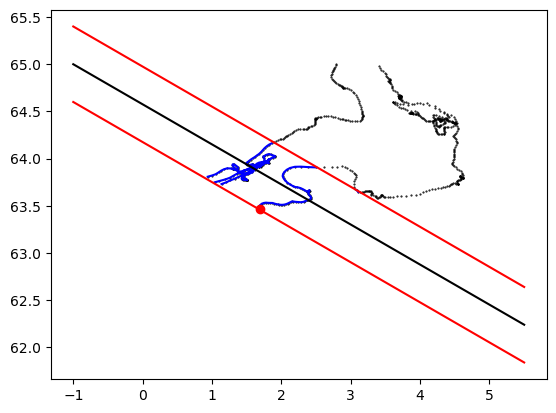

In [73]:
n=7
first_index_line_cross = ds_Svinoy_line_cross.isel(trajectory=i[n]).argmax(dim='obs').values

i = np.arange(10, ds.trajectory.size, 50_000)
plt.plot(ds_Svinoy.isel(trajectory=i[n]).lon, ds_Svinoy.isel(trajectory=i[n]).lat, 'k.', markersize=1)
plt.plot(ds_Svinoy_line.isel(trajectory=i[n]).lon, ds_Svinoy_line.isel(trajectory=i[n]).lat, 'b', markersize=1)
plt.plot([5.5, -1], [62.24, 65.], color='k')
plt.plot([5.5, -1], [62.24 + 0.4, 65 + 0.4], color='red')
plt.plot([5.5, -1], [62.24 - 0.4, 65 - 0.4], color='red')
plt.plot(ds_Svinoy_line.isel(trajectory=i[n]).lon[first_index_line_cross].values,
         ds_Svinoy_line.isel(trajectory=i[n]).lat[first_index_line_cross].values, 'ro', label='first crossing')
plt.show()

In [83]:
print(ds_Svinoy_line.isel(trajectory=i[n]).lon[first_index_line_cross].values)
print(ds_Svinoy_line.isel(trajectory=i[n]).lat[first_index_line_cross].values)

1.6931203342040322
63.4623765139492


397


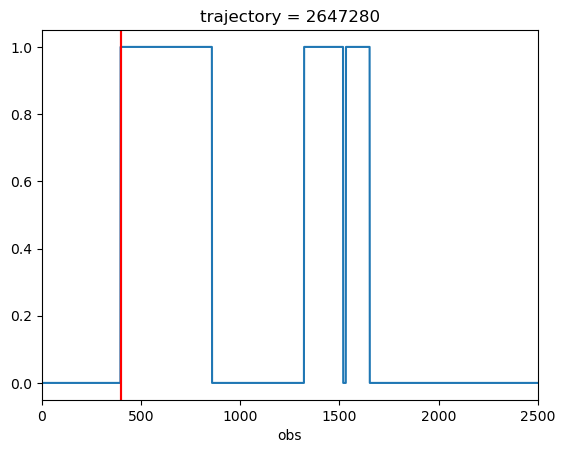

In [85]:
first_index = ds_Svinoy_window.isel(trajectory=i[n]).argmax(dim='obs').values
print(first_index)

ds_Svinoy_window.isel(trajectory=i[n]).plot()
#ds_Svinoy_line_cross.isel(trajectory=i[n]).plot()
plt.xlim(0,2500)
plt.axvline(x=first_index, color='r')
plt.axvline(x=first_index_line_cross, color='r')



(0.0, 2500.0)

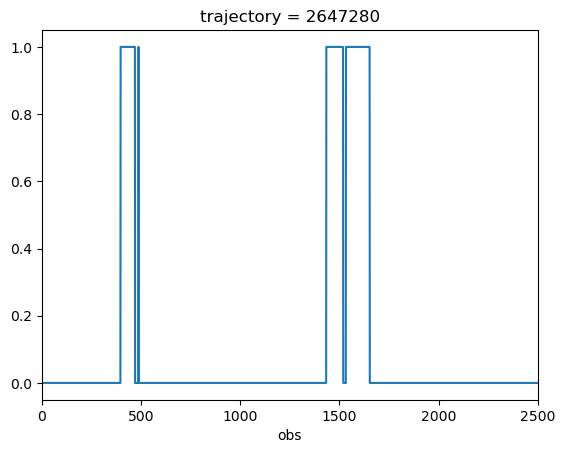

In [81]:
ds_Svinoy_line_cross.isel(trajectory=i[n]).plot()
plt.xlim(0,2500)

4016


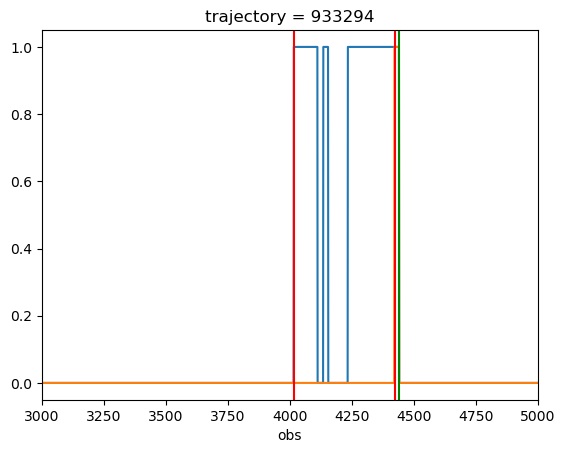

In [91]:
first_index = ds_Svinoy_window.isel(trajectory=i[3]).argmax(dim='obs').values
print(first_index)

ds_Svinoy_window.isel(trajectory=i[3]).plot()
ds_Svinoy_line_cross.isel(trajectory=i[3]).plot()
plt.xlim(3000,5000)
plt.axvline(x=first_index, color='r')
plt.axvline(x=first_index_line_cross, color='r')
plt.axvline(x=4440, color='g');


In [93]:
#ds_Svinoy_line_cross.argmax(dim='obs').sum(dim='trajectory').values

In [117]:
def get_unique_crossings(ds_line_cross):
    unique_crossings = (ds_line_cross.any(dim='obs')).sum(dim='trajectory').compute() 
    return unique_crossings.values


In [113]:
def check_overlap(section1, section2):
    # Check if particles cross both sections
    cross_section1 = section1.any(dim='obs')
    cross_section2 = section2.any(dim='obs')

    # Calculate overlap (particles that cross both sections)
    overlap_crossings = (cross_section1 & cross_section2).sum(dim='trajectory')

    overlap_crossings_cp = overlap_crossings.compute()
    print('Overlap crossings =', overlap_crossings_cp.values)

In [134]:
print('Svinoy and N', check_overlap(ds_Svinoy_line_cross,ds_N_line_cross))
print('Svinoy and EIC', check_overlap(ds_Svinoy_line_cross,ds_EIC_line_cross))
print('N and EIC',check_overlap(ds_N_line_cross,ds_EIC_line_cross))


Overlap crossings = 259889
Svinoy and N None
Overlap crossings = 160047
Svinoy and EIC None
Overlap crossings = 293166
N and EIC None


In [135]:
overlap_crossings = 259889
total_crossings = N_unique_crossings + Svinoy_unique_crossings
percentage_overlap = (overlap_crossings / total_crossings) * 100
percentage_overlap

35.42541605156872

In [137]:
(160047/(EIC_unique_crossings+Svinoy_unique_crossings))*100

27.355562316472444

In [136]:
(293166/(EIC_unique_crossings+N_unique_crossings))*100

39.724874693593826

In [101]:
N_unique_crossings = get_unique_crossings(ds_N_line_cross)
Svinoy_unique_crossings = get_unique_crossings(ds_Svinoy_line_cross)
EIC_unique_crossings = get_unique_crossings(ds_EIC_line_cross)

In [133]:
print('N section and Svinoy =', 100*N_unique_crossings/(Svinoy_unique_crossings + N_unique_crossings))
print('EIC and N =',100*EIC_unique_crossings/(EIC_unique_crossings + N_unique_crossings))
print('EIC and Svinoy =',100*EIC_unique_crossings/(EIC_unique_crossings + Svinoy_unique_crossings))


N section and Svinoy = 60.422860242931314
EIC and N = 39.93476885219467
EIC and Svinoy = 50.37329377057474


In [86]:
# ds_Svinoy_line_cross.isel(trajectory=3).plot()
# plt.show()
# ds_Svinoy_line_cross.isel(trajectory=4).plot()
# plt.show()
# ds_Svinoy_line_cross.isel(trajectory=5).plot()
# plt.show()
# ds_Svinoy_line_cross.isel(trajectory=6).plot()
# plt.show()
# ds_Svinoy_line_cross.isel(trajectory=7).plot()
# plt.show()
# ds_Svinoy_line_cross.isel(trajectory=8).plot()
# plt.show()

In [ ]:
# # #total_Svinoy_line_crossings = ds_Svinoy_line_cross.argmax(dim='obs')
# # ds_Svinoy_line_cross.argmax(dim='obs').isel(trajectory=-100).values

# total_Svinoy_line_crossings.plot();

In [96]:
# plt.pcolormesh(heat_map_normalized_Svinoy_cp.lon,heat_map_normalized_Svinoy_cp.lat,heat_map_normalized_Svinoy_cp.where(heat_map_normalized_Svinoy_cp>0),cmap='YlOrRd')
# plt.plot([5.5, -1], [62.24, 65.])
# plt.show()

In [73]:
# for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
#     ds_Svinoy_window.isel(trajectory=i).astype(int).plot()
#     plt.show()



In [91]:
# for i in tqdm.tqdm(np.arange(10,ds.trajectory.size,50_000)):
#     ds_Svinoy_window.isel(trajectory=i).drop_vars('trajectory').astype(int).diff('obs',1).plot()
#     plt.show()

In [170]:
ds_Svinoy_line.isel(trajectory=-199).drop_vars('trajectory').astype(int).diff('obs',1).plot()

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

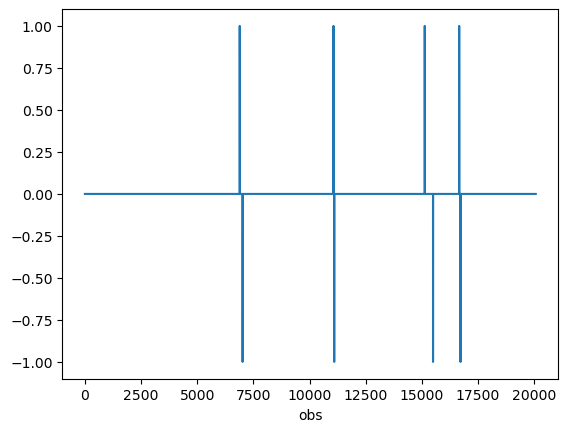

In [54]:
ds_Svinoy_window.isel(trajectory=-199).drop_vars('trajectory').astype(int).diff('obs',1).plot()

In [55]:
# #crossing_trajectories = []
# trajectory_positions = []

# for traj in tqdm.tqdm(range(20)):
#     lat_traj = Svinoy_box.lat.isel(trajectory=traj)
#     lon_traj = Svinoy_box.lon.isel(trajectory=traj)
#     #print(lon_traj)
#     y_line = m * lon_traj + b
#     #print(y_line)
#     trajectory_position = xr.where(lat_traj >= y_line, 1, 0)
#     trajectory_positions.append(trajectory_position)

# trajectory_positions = xr.concat(trajectory_positions, dim='trajectory')


In [ ]:
trajs = []
for traj in tqdm.tqdm(Svinoy.argmax('obs').isel(trajectory=slice(0, 30))):
    if traj > 0:
        trajs.append(ds.sel(trajectory=traj.trajectory).isel(obs=slice(0, traj.values)))
trajs = xr.concat(trajs,dim='trajectory')

In [138]:
import tqdm 


trajs = []
for traj in tqdm.tqdm(Svinoy.argmax('obs').isel(trajectory=slice(0, 30))):
    if traj > 0:
        trajs.append(ds.sel(trajectory=traj.trajectory).isel(obs=slice(0, traj.values)))
trajs = xr.concat(trajs,dim='trajectory')

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:29<00:00,  1.00it/s]


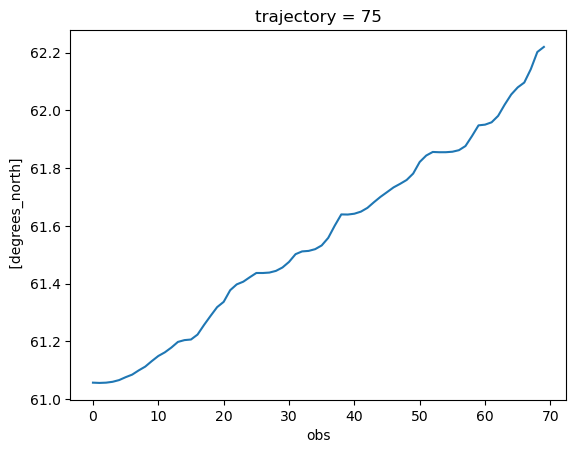

In [139]:
trajs.isel(trajectory=17).lat.plot()

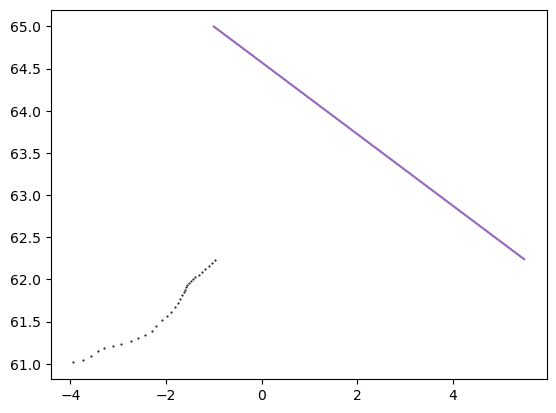

In [141]:
plt.plot(trajs.sel(trajectory=17).lon,trajs.sel(trajectory=17).lat,'k.',markersize=1)
plt.plot([5.5, -1], [62.24, 65.], color='tab:purple',label='west')

In [ ]:

# get heat map 
for i in tqdm.tqdm(range(trajs.trajectory.size)):
    plt.plot(trajs.isel(trajectory=i).lon,trajs.isel(trajectory=i).lat,'k.',markersize=1)
    plt.plot([5.5, -1], [62.24, 65.], color='tab:purple',label='west')

In [58]:
print(x1,y1, x2, y2)    

5.5 62.24 -1 65


In [69]:
#ds.isel(trajectory=1).lat.plot()

100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


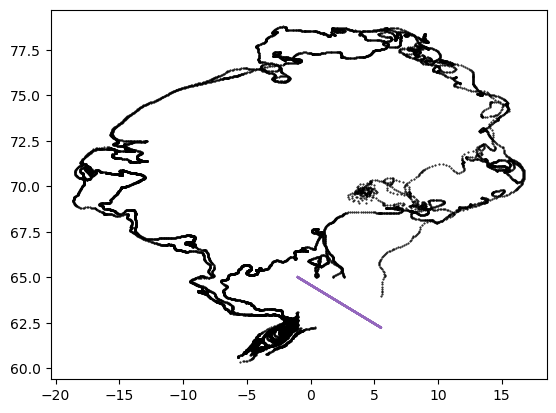

In [140]:
# get heat map 
for i in tqdm.tqdm(range(trajs.trajectory.size)):
    plt.plot(trajs.isel(trajectory=i).lon,trajs.isel(trajectory=i).lat,'k.',markersize=1)
    plt.plot([5.5, -1], [62.24, 65.], color='tab:purple',label='west')

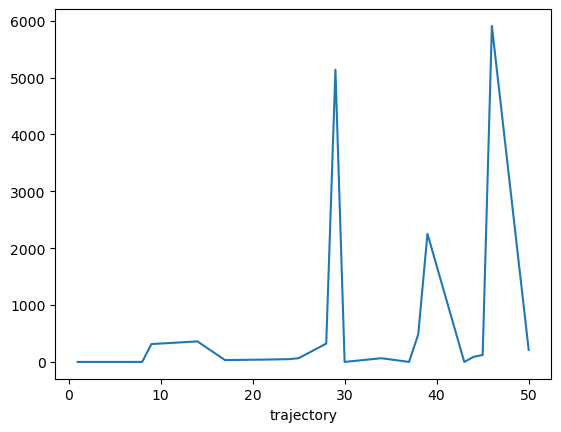

In [71]:
Svinoy.argmax('obs').isel(trajectory=slice(0,20)).plot();

In [149]:
trajs = []
for traj in tqdm.tqdm(Svinoy_box.isel(trajectory=slice(0, 30))):
    if traj > 0:
        trajs.append(ds.sel(trajectory=traj.trajectory).isel(obs=slice(0, traj.values)))
trajs = xr.concat(trajs, dim='trajectory')

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: '>' not supported between instances of 'str' and 'int'

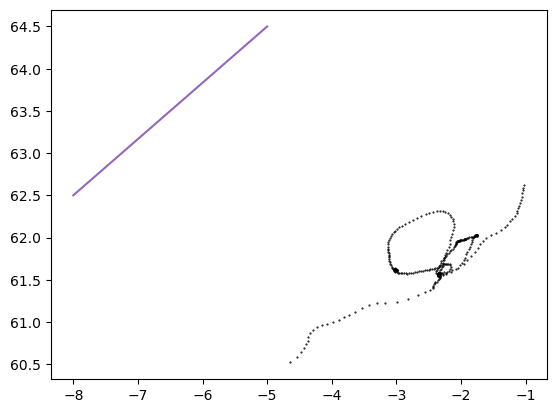

In [87]:
# get heat map 
plt.plot(trajs[0].lon,trajs[0].lat,'k.',markersize=1)
plt.plot([-8, -5], [62.5, 64.5], color='tab:purple',label='west')

In [14]:
trajs

[<xarray.Dataset>
 Dimensions:     (obs: 571)
 Coordinates:
   * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 563 564 565 566 567 568 569 570
     trajectory  int64 9
 Data variables:
     age         (obs) float32 dask.array<chunksize=(571,), meta=np.ndarray>
     lat         (obs) float64 dask.array<chunksize=(571,), meta=np.ndarray>
     lon         (obs) float64 dask.array<chunksize=(571,), meta=np.ndarray>
     salt        (obs) float32 dask.array<chunksize=(571,), meta=np.ndarray>
     temp        (obs) float32 dask.array<chunksize=(571,), meta=np.ndarray>
     time        (obs) datetime64[ns] dask.array<chunksize=(571,), meta=np.ndarray>
     uvel        (obs) float32 dask.array<chunksize=(571,), meta=np.ndarray>
     vvel        (obs) float32 dask.array<chunksize=(571,), meta=np.ndarray>
     z           (obs) float64 dask.array<chunksize=(571,), meta=np.ndarray>
     sigma0      (obs) float64 dask.array<chunksize=(571,), meta=np.ndarray>
 Attributes:
     Conventions:          

In [5]:
## assign a time to the start 

p=ds#.isel(trajectory=slice(0,1000,100))
p['start_time'] = p.isel(obs=0).time
p=p.set_coords('start_time')
p=p.set_xindex('start_time')

In [6]:
Svinoy = (ds.lon < 5.5) & (ds.lat > 62.24) & (ds.lon > -1) & (ds.lat < 65) 
VP = (ds.lon < 7) & (ds.lat > 66) & (ds.lon > 0) & (ds.lat > 68) 

# Define the first section
EIC = (ds.lon > -15) & (ds.lat > 66.25) & (ds.lon < -11.95) & (ds.lat < 68.7) 

# Define the second section

EAST = (ds.lon > 0) & (ds.lat < 64.5) & (ds.lon < 2.5) & (ds.lat > 62.5) 

# near release
REL = (ds.lon > -6.5) & (ds.lat < 62.1) & (ds.lon < 1) & (ds.lat > 60.5) 


In [7]:
ds_sigma_thresh = ds.where(ds.sigma0 > 28, drop=False)

In [9]:
# Initialize an empty dictionary to store mean meridional velocity over time
mean_vvel_over_time = {}

for r, ds_release in p.groupby('start_time'):
    print(r, end='')
    ds_rel = ds_sigma_thresh.sel(trajectory=ds_release.trajectory.values)
    mask = ((ds_rel.lon > -8) & (ds_rel.lat > 62.5) & (ds_rel.lon < -5) & (ds_rel.lat < 64.5))

    # Apply the mask to retain variables like vvel and temp
    ds_rel_masked = ds_rel.where(mask, drop=False)
    
    # Calculate the mean meridional velocity over the filtered dataset
    mean_vvel = ds_rel_masked['age'].mean(dim=['obs', 'trajectory']).compute()
    
    # Store the mean meridional velocity in the dictionary with the release time as the key
    mean_vvel_over_time[r] = mean_vvel.item()

# Now mean_vvel_over_time is a dictionary with release times as keys and mean meridional velocity as values


2003-01-01T00:00:00.000000000

Task exception was never retrieved
future: <Task finished name='Task-142935' coro=<Client._gather.<locals>.wait() done, defined at /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

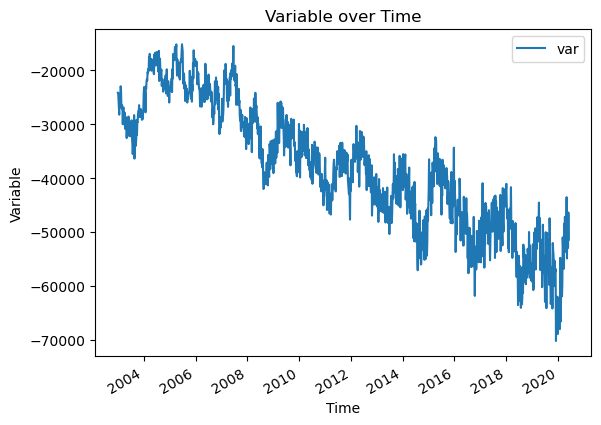

In [11]:
df = pd.DataFrame.from_dict(mean_vvel_over_time, orient='index', columns=['var'])

df.plot(y='var')
plt.xlabel('Time')
plt.ylabel('Variable')
plt.title('Variable over Time')
plt.show()

# trend is older with more recent release -- 10 years restriction


In [ ]:
df = pd.DataFrame.from_dict(mean_vvel_over_time, orient='index', columns=['var'])

df.plot(y='var')
plt.xlabel('Time')
plt.ylabel('Variable')
plt.title('Variable over Time')
plt.show()


In [12]:
df.to_csv('crossings/sigma0_thresh_age_per_release_WEST.csv') 

In [10]:
hours_to_days=0.0416667
hours_to_months=0.00136986
hours_to_years=0.000114155
time_conversion = hours_to_days

In [14]:
def read_csv(file):
    crossings_per_release = pd.read_csv('crossings/'+file)
    crossings_per_release = crossings_per_release.set_index('Unnamed: 0')
    crossings_per_release.index = pd.to_datetime(crossings_per_release.index)
    crossings_per_release = crossings_per_release.to_xarray()
    crossings_per_release = crossings_per_release.rename({'Unnamed: 0': 'time'})
    return crossings_per_release

age_per_release_WEST = read_csv('age_per_release_WEST.csv')

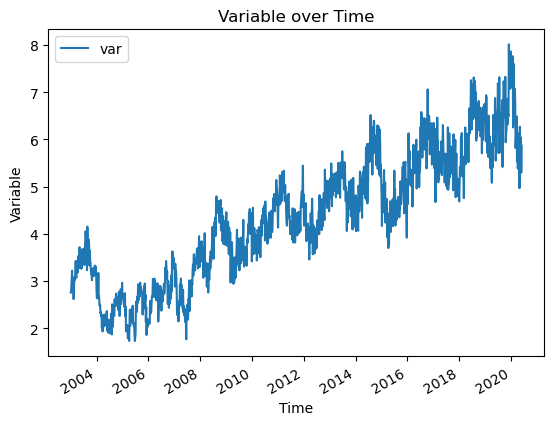

In [18]:
(-hours_to_years*df).plot(y='var')
plt.xlabel('Time')
plt.ylabel('Variable')
plt.title('Variable over Time')
plt.show()

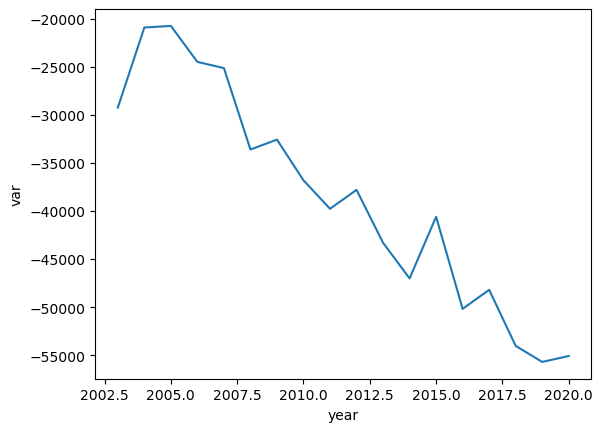

In [16]:
age_per_release_WEST['var'].groupby('time.year').mean(dim='time').plot()

In [4]:
crossings_per_release_WEST = read_csv('crossings_per_release_WEST.csv')
crossings_per_release_EAST = read_csv('crossings_per_release_EAST.csv')
crossings_per_release_EIC = read_csv('crossings_per_release_EIC.csv')
crossings_per_release_Svinoy = read_csv('crossings_per_release_Svinoy.csv')
crossings_per_release_VP = read_csv('crossings_per_release_VP.csv')

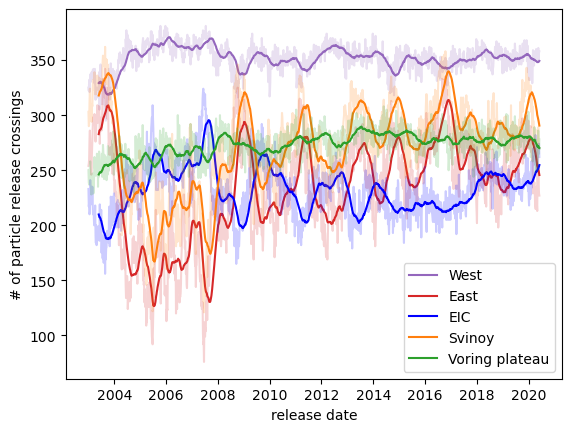

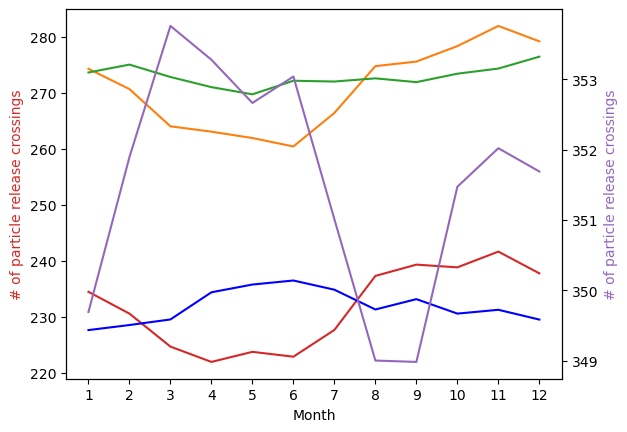

In [25]:
plt.plot(crossings_per_release_WEST.time, crossings_per_release_WEST.crossings_west,color='tab:purple', alpha=0.2)
plt.plot(crossings_per_release_WEST.time,crossings_per_release_WEST.crossings_west.rolling(time=30).mean(dim='time'),color='tab:purple',
                                                                                                         label='West')
plt.plot(crossings_per_release_EAST.time, crossings_per_release_EAST.crossings_east,color='tab:red', alpha=0.2)
plt.plot(crossings_per_release_EAST.time,crossings_per_release_EAST.crossings_east.rolling(time=30).mean(dim='time'),color='tab:red',
         label='East')

plt.plot(crossings_per_release_EIC.time, crossings_per_release_EIC.crossings_eic,color='blue', alpha=0.2)
plt.plot(crossings_per_release_EIC.time,crossings_per_release_EIC.crossings_eic.rolling(time=30).mean(dim='time'),color='blue',
         label='EIC')

plt.plot(crossings_per_release_Svinoy.time, crossings_per_release_Svinoy['var'], color='tab:orange', alpha=0.2)
plt.plot(crossings_per_release_Svinoy.time, crossings_per_release_Svinoy['var'].rolling(time=30).mean(dim='time'), color='tab:orange', label='Svinoy')

plt.plot(crossings_per_release_VP.time, crossings_per_release_VP['var'], color='tab:green', alpha=0.2)
plt.plot(crossings_per_release_VP.time, crossings_per_release_VP['var'].rolling(time=30).mean(dim='time'), color='tab:green', label='Voring plateau')

plt.xlabel('release date')
plt.ylabel('# of particle release crossings')
plt.legend()
plt.show()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(np.arange(1, 13), crossings_per_release_EAST.groupby('time.month').mean(dim='time').crossings_east, color='tab:red',
         label='east')

ax1.plot(np.arange(1, 13), crossings_per_release_EIC.groupby('time.month').mean(dim='time').crossings_eic, color='blue',
         label='EIC')

ax2.plot(np.arange(1, 13), crossings_per_release_WEST.groupby('time.month').mean(dim='time').crossings_west, color='tab:purple',
         label='west')

ax1.plot(np.arange(1, 13), crossings_per_release_Svinoy.groupby('time.month').mean(dim='time')['var'], color='tab:orange',
         label='Svinoy')

ax1.plot(np.arange(1, 13), crossings_per_release_VP.groupby('time.month').mean(dim='time')['var'], color='tab:green',
         label='Voring plateau')

ax1.set_xlabel('Month')
ax1.set_ylabel('# of particle release crossings', color='tab:red')
ax2.set_ylabel('# of particle release crossings', color='tab:purple')
# ax1.legend()
# ax2.legend()
plt.xticks(np.arange(1, 13))
plt.show()



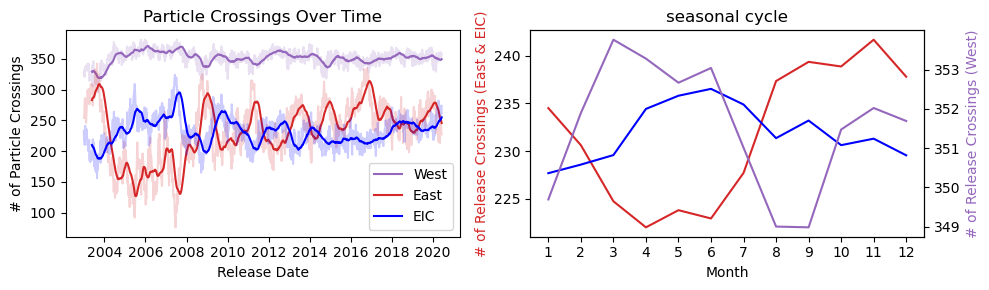

In [75]:
# Assuming crossings_per_release_WEST, crossings_per_release_EAST, and crossings_per_release_EIC are already defined

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# First plot: Time series of crossings
ax1.plot(crossings_per_release_WEST.time, crossings_per_release_WEST.crossings_west, color='tab:purple', alpha=0.2)
ax1.plot(crossings_per_release_WEST.time, crossings_per_release_WEST.crossings_west.rolling(time=30).mean(dim='time'), color='tab:purple', label='West')
ax1.plot(crossings_per_release_EAST.time, crossings_per_release_EAST.crossings_east, color='tab:red', alpha=0.2)
ax1.plot(crossings_per_release_EAST.time, crossings_per_release_EAST.crossings_east.rolling(time=30).mean(dim='time'), color='tab:red', label='East')
ax1.plot(crossings_per_release_EIC.time, crossings_per_release_EIC.crossings_eic, color='blue', alpha=0.2)
ax1.plot(crossings_per_release_EIC.time, crossings_per_release_EIC.crossings_eic.rolling(time=30).mean(dim='time'), color='blue', label='EIC')

ax1.set_xlabel('Release Date')
ax1.set_ylabel('# of Particle Crossings')
ax1.legend()
ax1.set_title('Particle Crossings Over Time')

# Second plot: Monthly averages
ax2_twin = ax2.twinx()  # Create a twin y-axis for the second plot
ax2.plot(np.arange(1, 13), crossings_per_release_EAST.groupby('time.month').mean(dim='time').crossings_east, color='tab:red', label='East')
ax2.plot(np.arange(1, 13), crossings_per_release_EIC.groupby('time.month').mean(dim='time').crossings_eic, color='blue', label='EIC')
ax2_twin.plot(np.arange(1, 13), crossings_per_release_WEST.groupby('time.month').mean(dim='time').crossings_west, color='tab:purple', label='West')

ax2.set_xlabel('Month')
ax2.set_ylabel('# of Release Crossings (East & EIC)', color='tab:red')
ax2_twin.set_ylabel('# of Release Crossings (West)', color='tab:purple')
ax2.set_title('seasonal cycle')

# Set x-ticks for the second plot
ax2.set_xticks(np.arange(1, 13))

# Adjust layout
plt.tight_layout()
plt.show()


In [9]:
months = np.arange(1, 13)

In [10]:
temp_release_EIC = read_csv('temp_per_release_EIC.csv')
temp_release_WEST = read_csv('temp_per_release_WEST.csv')
temp_release_EAST = read_csv('temp_per_release_EAST.csv')
temp_release_Svinoy = read_csv('temp_per_release_Svinoy.csv')
temp_release_VP = read_csv('temp_per_release_VP.csv')

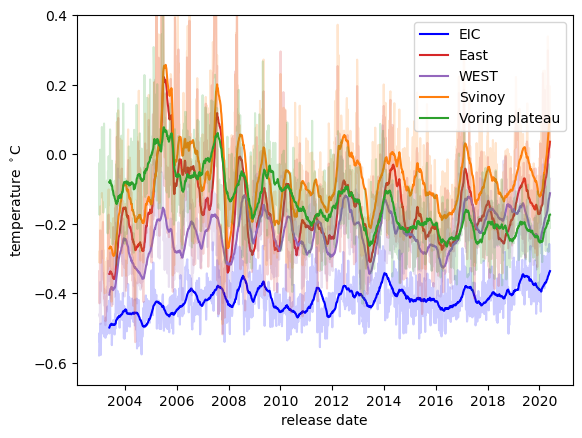

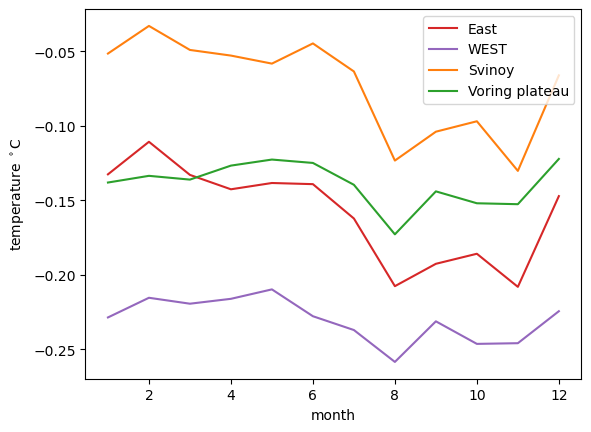

In [27]:
plt.plot(temp_release_EIC.time,temp_release_EIC['var'],color='blue', alpha=0.2)
plt.plot(temp_release_EIC.time,temp_release_EIC['var'].rolling(time=30).mean(dim='time'),color='blue',
         label='EIC')

plt.plot(temp_release_EAST.time, temp_release_EAST['var'],color='tab:red', alpha=0.2)
plt.plot(temp_release_EAST.time,temp_release_EAST['var'].rolling(time=30).mean(dim='time'),color='tab:red',
         label='East')

plt.plot(temp_release_WEST.time,temp_release_WEST['var'],color='tab:purple', alpha=0.2)
plt.plot(temp_release_WEST.time,temp_release_WEST['var'].rolling(time=30).mean(dim='time'),color='tab:purple',
         label='WEST')

plt.plot(temp_release_Svinoy.time, temp_release_Svinoy['var'], color='tab:orange', alpha=0.2)
plt.plot(temp_release_Svinoy.time, temp_release_Svinoy['var'].rolling(time=30).mean(dim='time'), color='tab:orange', label='Svinoy')

plt.plot(temp_release_VP.time, temp_release_VP['var'], color='tab:green', alpha=0.2)
plt.plot(temp_release_VP.time, temp_release_VP['var'].rolling(time=30).mean(dim='time'), color='tab:green', label='Voring plateau')

plt.ylabel(r'temperature $^\circ$C')
plt.xlabel('release date')
plt.ylim(None,.4)
plt.legend()
plt.show()

# plt.plot(np.arange(1, 13),temp_release_EIC['var'].groupby('time.month').mean(dim='time'),color='blue', alpha=0.2)
# plt.plot(np.arange(1, 13),temp_release_EIC['var'].groupby('time.month').mean(dim='time'),color='blue',
#          label='EIC')

plt.plot(np.arange(1, 13),temp_release_EAST['var'].groupby('time.month').mean(dim='time'),color='tab:red',
         label='East')

plt.plot(np.arange(1, 13),temp_release_WEST['var'].groupby('time.month').mean(dim='time'),color='tab:purple',
         label='WEST')

plt.plot(np.arange(1, 13), temp_release_Svinoy['var'].groupby('time.month').mean(dim='time'), color='tab:orange', label='Svinoy')

plt.plot(np.arange(1, 13), temp_release_VP['var'].groupby('time.month').mean(dim='time'), color='tab:green', label='Voring plateau')

plt.ylabel(r'temperature $^\circ$C')
plt.xlabel('month')
#plt.ylim(None,.4)
plt.legend()
plt.show()

In [15]:
salt_release_EIC = read_csv('salt_per_release_EIC.csv')
salt_release_WEST = read_csv('salt_per_release_WEST.csv')
salt_release_EAST = read_csv('salt_per_release_EAST.csv')
salt_release_Svinoy = read_csv('salt_per_release_Svinoy.csv')
salt_release_VP = read_csv('salt_per_release_VP.csv')

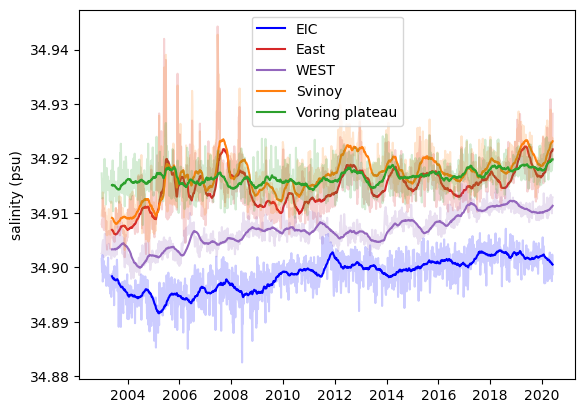

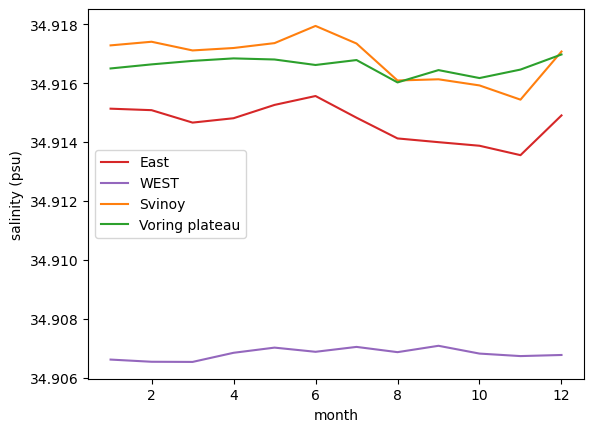

In [29]:
plt.plot(salt_release_EIC.time, salt_release_EIC['var'], color='blue', alpha=0.2)
plt.plot(salt_release_EIC.time, salt_release_EIC['var'].rolling(time=30).mean(dim='time'), color='blue', label='EIC')

plt.plot(salt_release_EAST.time, salt_release_EAST['var'], color='tab:red', alpha=0.2)
plt.plot(salt_release_EAST.time, salt_release_EAST['var'].rolling(time=30).mean(dim='time'), color='tab:red', label='East')

plt.plot(salt_release_WEST.time, salt_release_WEST['var'], color='tab:purple', alpha=0.2)
plt.plot(salt_release_WEST.time, salt_release_WEST['var'].rolling(time=30).mean(dim='time'), color='tab:purple', label='WEST')


plt.plot(salt_release_Svinoy.time, salt_release_Svinoy['var'], color='tab:orange', alpha=0.2)
plt.plot(salt_release_Svinoy.time, salt_release_Svinoy['var'].rolling(time=30).mean(dim='time'), color='tab:orange', label='Svinoy')

plt.plot(salt_release_VP.time, salt_release_VP['var'], color='tab:green', alpha=0.2)
plt.plot(salt_release_VP.time, salt_release_VP['var'].rolling(time=30).mean(dim='time'), color='tab:green', label='Voring plateau')

plt.ylabel(r'salinity (psu)')
#plt.ylim(None,.4)
plt.legend()
plt.show()


# plt.plot(np.arange(1, 13),salt_release_EIC['var'].groupby('time.month').mean(dim='time'),color='blue',
#         label='EIC')

plt.plot(np.arange(1, 13), salt_release_EAST['var'].groupby('time.month').mean(dim='time'), color='tab:red', label='East')

plt.plot(np.arange(1, 13), salt_release_WEST['var'].groupby('time.month').mean(dim='time'), color='tab:purple', label='WEST')

plt.plot(np.arange(1, 13), salt_release_Svinoy['var'].groupby('time.month').mean(dim='time'), color='tab:orange', label='Svinoy')

plt.plot(np.arange(1, 13), salt_release_VP['var'].groupby('time.month').mean(dim='time'), color='tab:green', label='Voring plateau')

plt.ylabel(r'salinity (psu)')
plt.xlabel('month')
#plt.ylim(None,.4)
plt.legend()
plt.show()


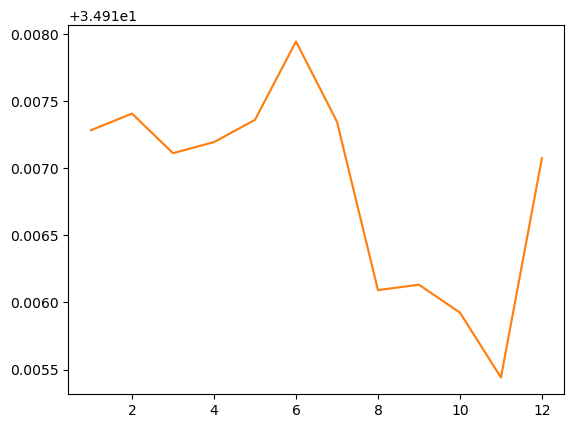

In [20]:

plt.plot(np.arange(1, 13), salt_release_Svinoy['var'].groupby('time.month').mean(dim='time'), color='tab:orange', alpha=0.2)
plt.plot(np.arange(1, 13), salt_release_Svinoy['var'].groupby('time.month').mean(dim='time'), color='tab:orange', label='Svinoy')


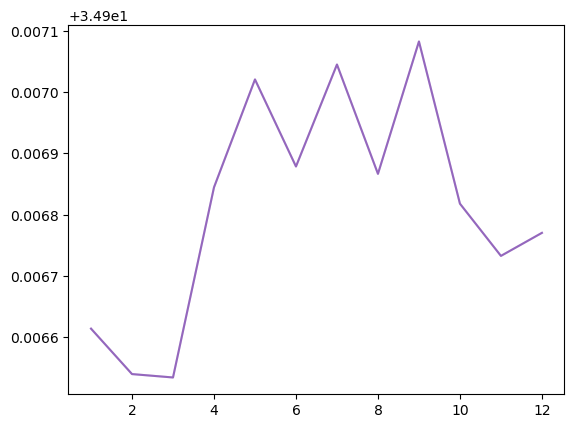

In [21]:

plt.plot(np.arange(1, 13), salt_release_WEST['var'].groupby('time.month').mean(dim='time'), color='tab:purple', alpha=0.2)
plt.plot(np.arange(1, 13), salt_release_WEST['var'].groupby('time.month').mean(dim='time'), color='tab:purple', label='WEST')


In [2]:
cluster = dask_jobqueue.SLURMCluster(

    # Dask worker size
    cores=4, memory='16GB',
    processes=1, # Dask workers per job
    
    # SLURM job script things
    queue='base', walltime='04:00:00',
    
    # Dask worker network and temporary storage
    interface='ib0', local_directory='$TMPDIR',  # for spilling tmp data to disk
    log_directory='slurm/' 
)

client = dask.distributed.Client(cluster)

cluster.scale(jobs=4)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.18.4.20:8787/status,
Dashboard: http://172.18.4.20:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.18.4.20:39213,Workers: 0
Dashboard: http://172.18.4.20:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
ds = xr.open_dataset('data/level2/parcels_releases_seed-2345.zarr', engine='zarr', chunks='auto')


In [29]:
ds = xr.open_dataset('/GLORYS12/parcels_expts_trial/S_T_backwards_trial_V_sec.zarr')

FileNotFoundError: No such file or directory: '/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/GLORYS12/parcels_expts_trial/S_T_backwards_trial_V_sec.zarr'

In [4]:
particles_reach_zero_salinity = (ds.salt == 0).any('obs')

particles_beached = ~particles_reach_zero_salinity

# Filter the dataset to include only particles that reach zero salinity
ds_particles_reach_zero_salinity_beached = ds.where(particles_beached, drop=False)

dataset = ds_particles_reach_zero_salinity_beached

In [23]:
dataset.time.isel(trajectory=4).values[:10]

array(['2003-01-01T00:00:00.000000000', '2002-12-31T12:00:01.000000000',
       '2002-12-31T00:00:00.000000000', '2002-12-30T12:00:01.000000000',
       '2002-12-30T00:00:00.000000000', '2002-12-29T12:00:01.000000000',
       '2002-12-29T00:00:00.000000000', '2002-12-28T12:00:01.000000000',
       '2002-12-28T00:00:00.000000000', '2002-12-27T12:00:01.000000000'],
      dtype='datetime64[ns]')

In [20]:
help(ltt)

Help on package lt_toolbox:

NAME
    lt_toolbox

DESCRIPTION
    ##############################################################################
    # __init__.py
    #
    # Description:
    # __init__ file in order for lt_toolbox directory to be treated
    # as a package of modules.
    #
    # Last Edited:
    # 2021-07-15
    #
    # Created By:
    # Ollie Tooth
    #
    ###############################################################################

PACKAGE CONTENTS
    conversions (package)

SUBMODULES
    trajframe

FILE
    /gxfs_home/geomar/smomw452/miniconda3/envs/py3_std_maps_2023-11-20/lib/python3.12/site-packages/lt_toolbox/__init__.py




In [21]:
# traj = ltt.TrajArray(ds=dataset)
# print(traj)

traj = ltt.TrajFrame(source=dataset.unify_chunks(), condense=True)


KeyboardInterrupt: 

In [11]:
dir(ltt)

['TrajFrame',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'trajframe']

In [ ]:
ltt.__version__